In [1]:
data_path = "Conway_GPT_v8\\"

test_file = data_path + "conway_test_states_32by32_20240827_172807.csv"

import pandas as pd
df_test = pd.read_csv(test_file)

future_steps_list = [2]
start_char = '@'
end_char = '$'
mask_char = ['_']
# Function to generate data
def generate_data(df, future_steps):
    X_data = []
    for i in range(len(df['State 1'])):
        future_state_col = f'State {future_steps}'
        if future_state_col in df.columns:
            str_ = f"{start_char}PredictNextState<{df['State 1'][i]}> [{df[future_state_col][i]}]{end_char}"
            X_data.append(str_)
    return X_data
X_data_test = {steps: generate_data(df_test, steps) for steps in future_steps_list}

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

X_data_test_new=X_data_test[2]



In [2]:
for ii in range(len(X_data_test_new)):
    print(X_data_test_new[ii])


@PredictNextState<0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from x_transformers import TransformerWrapper, Decoder
from x_transformers.autoregressive_wrapper import AutoregressiveWrapper
import typing
import imageio
from datetime import datetime

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

class Tokenizer:
    def __init__(self, n_pad: int, device: torch.device, pad_byte: int = 0):
        self.n_pad = n_pad
        self.device = device
        self.pad_byte = pad_byte

    def tokenize_str(self, sentence: str, encoding="utf8", do_padding=True):
        base = list(bytes(sentence, encoding))
        if do_padding:
            if len(base) < self.n_pad:
                base.extend([self.pad_byte] * (self.n_pad - len(base)))
            assert len(base) == self.n_pad, f"n_pad is too small, use {len(base)} or greater."
        tensor = torch.Tensor(base)
        return tensor.long().to(self.device)

    def texts_to_sequences(self, texts: typing.List[str], encoding="utf8", do_padding=True):
        sentences = [self.tokenize_str(sentence, do_padding=do_padding).unsqueeze(0) for sentence in texts]
        return torch.cat(sentences, dim=0).to(self.device)

    def sequences_to_texts(self, texts: torch.Tensor, encoding="utf8"):
        out = []
        for seq in texts:
            chars = []
            i = 0
            while i < len(seq) and seq[i] != 0:
                chars.append(int(seq[i]))
                i += 1
            try:
                out.append(bytes(chars).decode(encoding))
            except:
                pass
        return out

def empty_cuda_cache():
    torch.cuda.empty_cache()

def load_model(model_path, max_length, num_words):
    empty_cuda_cache()
    
    model = TransformerWrapper(
        num_tokens=num_words,
        max_seq_len=max_length,
        attn_layers=Decoder(
            dim=256,
            depth=12,
            heads=8,
            attn_dim_head=64,
            rotary_pos_emb=True,
            attn_flash=True
        )
    )
    model = AutoregressiveWrapper(model)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval
    print(f"Model loaded from {model_path}")
    
    return model

def extract_task(string_input, end_task_token='>'):
    j = string_input.find(end_task_token)
    return string_input[:j+1]

def extract_sample(string_input, start_token='[', end_token=']'):
    i = string_input.find(start_token)
    j = string_input.find(end_token)
    return string_input[i+1:j]

def display_and_save_images(initial_input, data_list, temp, base_dir="output_gifs"):
    num_states = len(data_list) + 1  # Include the initial input as the first state
    images = []

    plt.figure(figsize=(15, 5))

    # Convert and plot the initial input state
    initial_image = convert_to_square_image(initial_input)
    plt.subplot(1, num_states, 1)
    plt.title(f"State 1")
    plt.imshow(1 - initial_image, cmap='gray', vmin=0, vmax=1)  # Corrected color inversion
    plt.axis('off')
    images.append(1 - initial_image)

    # Convert and plot the subsequent states
    for i, data in enumerate(data_list):
        image = convert_to_square_image(data)
        plt.subplot(1, num_states, i + 2)
        plt.title(f"State {i + 2}")
        plt.imshow(1 - image, cmap='gray', vmin=0, vmax=1)  # Corrected color inversion
        plt.axis('off')
        images.append(1 - image)

    plt.show()

    temp_folder = os.path.join(base_dir, f"temp_{temp}")
    os.makedirs(temp_folder, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    gif_path = os.path.join(temp_folder, f"sequence_{timestamp}.gif")
    mp4_path = os.path.join(temp_folder, f"sequence_{timestamp}.mp4")

    # Ensure all images are in RGB format for MP4
    images_rgb = [np.stack([img, img, img], axis=-1) * 255 for img in images]  # Scale to 255 for OpenCV

    # Save as GIF
    imageio.mimsave(gif_path, images_rgb, format='GIF', duration=200, loop=0)

    # Save as MP4 using OpenCV
    height, width = images_rgb[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
    out = cv2.VideoWriter(mp4_path, fourcc, 5, (width, height))  # 5 fps

    for img in images_rgb:
        out.write(np.uint8(img))  # Convert to uint8 for OpenCV

    out.release()

    print(f"Saved ground truth GIF at {gif_path}")
    print(f"Saved ground truth MP4 at {mp4_path}")

def convert_to_square_image(state):
    length = len(state)
    size = int(np.sqrt(length))
    assert size * size == length, "State length is not a perfect square"
    image = np.array([int(pixel) for pixel in state]).reshape((size, size))
    return image

def parse_and_convert_ground_truth(df, index):
    """
    Parses the ground truth data from the DataFrame and returns a list of states.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the ground truth data.
    index (int): The index of the row to extract.
    
    Returns:
    list of str: List of string representations of the states.
    """
    # Extract the states from the columns 'State 1', 'State 2', ..., 'State 10'
    state_columns = [f'State {i}' for i in range(1, 251)]
    states = df.loc[index, state_columns].tolist()
    
    return states

def display_and_save_ground_truth_gif(df, row_index, base_dir="ground_truth_gifs", scale_factor=10):
    states = df.iloc[row_index].tolist()
    images = [convert_to_square_image(state) for state in states]

    # Increase the resolution of the images for GIF and video
    images_resized = [cv2.resize(img, (img.shape[1] * scale_factor, img.shape[0] * scale_factor), interpolation=cv2.INTER_NEAREST) for img in images]

    # Invert colors: making the cells black (value 0) and the background white (value 255)
    images_inverted = [255 - (img * 255).astype(np.uint8) for img in images_resized]  # Convert binary 0/1 to 0/255, invert, and cast to uint8

    # Convert to RGB format
    images_rgb = [np.stack([img, img, img], axis=-1) for img in images_inverted]  # RGB stack
    
    # Save as GIF
    gif_path = os.path.join(base_dir, f"ground_truth_row_{row_index}.gif")
    imageio.mimsave(gif_path, images_rgb, format='GIF', duration=200, loop=0)
    
    # Save as MP4 using OpenCV
    mp4_path = os.path.join(base_dir, f"ground_truth_row_{row_index}.mp4")
    height, width = images_rgb[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
    out = cv2.VideoWriter(mp4_path, fourcc, 5, (width, height))  # 5 fps

    for img in images_rgb:
        out.write(img)

    out.release()

    print(f"Saved ground truth GIF at {gif_path}")
    print(f"Saved ground truth MP4 at {mp4_path}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000202E3B7B220>>
Traceback (most recent call last):
  File "c:\Users\jaime\anaconda3\envs\ML_Playground_1\lib\site-packages\ipykernel\ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
device

device(type='cuda')

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from datetime import datetime

def save_data_to_csv(df, row_indices, autoreg_list, temp, base_dir="ARAR", step=None, sample_id=None):
    """
    Saves the ground truth and autoregressively generated data into a CSV file.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the ground truth data.
    row_indices (list of int): List of indices corresponding to the rows in the DataFrame to extract ground truth states.
    autoreg_list (list of list of str): List containing lists of string data representing the autoregressively generated states.
    temp (float): The temperature used for generating the states.
    base_dir (str): Base directory to save the CSV file.
    step (int, optional): The current generation step number.
    sample_id (int, optional): Identifier for the current sample.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(base_dir, exist_ok=True)
    
    # Create a subdirectory for each sample if sample_id is provided
    if sample_id is not None:
        sample_dir = os.path.join(base_dir, f"sample_{sample_id}")
        os.makedirs(sample_dir, exist_ok=True)
    else:
        sample_dir = base_dir

    # Prepare data for saving
    data = []
    for i, row_index in enumerate(row_indices):
        gt_states = parse_and_convert_ground_truth(df, row_index)
        autoreg_states = autoreg_list[i]
        
        # Ensure the initial state is included in both rows
        initial_state = gt_states[0]
        
        gt_row = [initial_state] + gt_states[1:]  # Ground truth row
        autoreg_row = [initial_state] + autoreg_states  # Autoregressive row

        data.append(["Ground Truth"] + gt_row)
        data.append(["Autoregressive"] + autoreg_row)
    
    # Convert to DataFrame for easier saving
    columns = ["Type"] + [f"State {i + 1}" for i in range(len(gt_row))]
    data_df = pd.DataFrame(data, columns=columns)
    
    # Determine which version to save based on the step
    version = step % 2 + 1 if step is not None else 1
    csv_filename = f"data_temp_{temp}_epoch_50_sample_{sample_id}_v{version}.csv"
    csv_path = os.path.join(sample_dir, csv_filename)
    
    # Save the DataFrame to a CSV file
    data_df.to_csv(csv_path, index=False)
    print(f"Saved data to CSV at {csv_path}")

def autoregressive_generation(model, tokenizer, initial_input_str, num_steps, temp, ground_truth_df, row_index, base_dir="ARAR", sample_id=None):
    current_input = extract_task(initial_input_str, end_task_token='>')
    generated_states = []

    for step in range(num_steps):
        current_input_tensor = torch.Tensor(tokenizer.texts_to_sequences(current_input, do_padding=False)).to(device)
        current_input_tensor = current_input_tensor.transpose(0, 1).long()

        with torch.no_grad():
            sample = model.generate(
                prompts=current_input_tensor,
                seq_len=generate_length,
                temperature=temp,
                cache_kv=True
            )

        output_str = extract_sample(tokenizer.sequences_to_texts(sample[:1])[0])
        print(f"Output: {output_str}")
        generated_states.append(output_str)

        # Save the CSV after each generation step, passing the sample_id
        save_data_to_csv(ground_truth_df, [row_index], [generated_states], temp, base_dir, step, sample_id)

        # Update the input for the next step
        current_input = f"@PredictNextState<{output_str}>"

        del sample, current_input_tensor
        torch.cuda.empty_cache()

    return generated_states

# Assuming X_data_test[2] is already defined
X_data_test_new = X_data_test[2]

# Calculate max_length and generate_length dynamically
max_length = len(X_data_test_new[0])
generate_length = max_length - len("@PredictNextState<>") - (32 * 32)

# Initialize tokenizer
tokenizer_X = Tokenizer(max_length, device)

# Load the model for epoch 50
epoch = 50
model_path = f"model_parameters\\07_22_2024_Conway_2_State_Jump_Rot_Pos_On_Masking_On_Broad_Entrpoy_Homog_2024-07-23 10-37-31\\Conway_GPT_v7_epoch_{epoch}.pt"
model = load_model(model_path, max_length, num_words=256)

# Define the temperatures
temperatures = [0]

# Generate and save the states
num_steps = 249  # Number of steps to generate autoregressively
ground_truth_df = df_test  # Use the df_test DataFrame for ground truth data

for temp in temperatures:
    print(f"Generating for temperature {temp}...")
    
    for i, item in enumerate(X_data_test_new):
        # Take the initial input from the test data
        initial_input_str = str(item)
        id = i+1
        # Generate subsequent states and save after each step, passing the sample index as sample_id
        autoregressive_generation(model, tokenizer_X, initial_input_str, num_steps, temp, ground_truth_df, i, sample_id=id)

        torch.cuda.empty_cache()


Model loaded from model_parameters\07_22_2024_Conway_2_State_Jump_Rot_Pos_On_Masking_On_Broad_Entrpoy_Homog_2024-07-23 10-37-31\Conway_GPT_v7_epoch_50.pt
Generating for temperature 0...
Output: 00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob

def plot_image(ax, state, ylabel, cmap):
    """
    Plots an image from the state data.

    Parameters:
    ax (Axes): The axes to plot on.
    state (str): The state as a string of 0s and 1s.
    ylabel (str): The label for the y-axis.
    cmap (str): The color map for the image.
    """
    ax.set_ylabel(ylabel, fontsize=10, rotation=90, labelpad=10, va='center')
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Turn off ticks and labels
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)  # Set the width of the spines
    if not is_perfect_square(len(state)) or not check_state_length(state):
        ax.text(0.5, 0.5, "DATA NOT SQUARE", fontsize=10, ha='center', va='center', rotation=45)
    else:
        ax.imshow(1 - convert_to_square_image(state, cell_size=10), cmap=cmap, vmin=0, vmax=1)

def plot_discrepancy(ax, discrepancy_matrix, ylabel):
    """
    Plots the discrepancy matrix.

    Parameters:
    ax (Axes): The axes to plot on.
    discrepancy_matrix (ndarray): The discrepancy matrix to plot.
    ylabel (str): The label for the y-axis.
    """
    sns.heatmap(discrepancy_matrix, cmap="plasma", cbar=False, square=True, ax=ax)
    ax.set_ylabel(ylabel, fontsize=10, rotation=90, labelpad=10, va='center')
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Turn off ticks and labels

def calculate_discrepancy_matrix(gt_state, pred_state):
    """
    Calculate the discrepancy matrix between GT and Predicted states.

    Parameters:
    gt_state (str): The ground truth state.
    pred_state (str): The predicted state.

    Returns:
    np.ndarray: The discrepancy matrix.
    """
    # Ensure gt_state and pred_state are strings of length 1024
    if isinstance(gt_state, str) and isinstance(pred_state, str):
        if len(gt_state) == len(pred_state) == 1024:
            discrepancy_matrix = np.array([
                1 if gt_state[k] != pred_state[k] else 0
                for k in range(len(gt_state))
            ]).reshape((32, 32))
        else:
            print('State lengths are not 1024, creating default discrepancy matrix.')
            discrepancy_matrix = np.full((32, 32), 0.5)  # Handle error gracefully
    else:
        print('States are not strings, creating default discrepancy matrix.')
        discrepancy_matrix = np.full((32, 32), 0.5)  # Handle error gracefully
    
    return discrepancy_matrix

def convert_to_square_image(state, cell_size=1):
    """
    Converts a string state representation into a square image with adjustable cell size.
    
    Parameters:
    state (str): The state as a string of 0s and 1s.
    cell_size (int): The size of each cell in pixels. Default is 1.
    
    Returns:
    2D numpy array representing the square image with adjusted cell size.
    """
    length = len(state)
    size = int(np.sqrt(length))
    assert size * size == length, "State length is not a perfect square"
    image = np.array([int(pixel) for pixel in state]).reshape((size, size))
    
    # Adjust the cell size by repeating the rows and columns
    image = np.kron(image, np.ones((cell_size, cell_size)))
    
    return image

def is_perfect_square(length):
    """
    Check if a number is a perfect square.
    """
    size = int(np.sqrt(length))
    return size * size == length

def check_state_length(state):
    """
    Check if the state has 1024 entries.
    """
    return len(state) == 1024

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob

# ... (previous functions remain unchanged)

def create_sample_figures(base_dir, output_dir="Figures/Epoch 50 Figures"):
    """
    Creates figures for each sample showing selected states with ground truth, predicted, and discrepancy.

    Parameters:
    base_dir (str): Base directory containing subfolders for each sample.
    output_dir (str): Directory to save the generated figures.
    """
    # Create output directory if not exists
    os.makedirs(output_dir, exist_ok=True)

    # Get all sample subfolders
    sample_folders = [f.path for f in os.scandir(base_dir) if f.is_dir() and f.name.startswith("sample_")]

    # States to display in the figure
    states_to_plot = [1, 2, 3, 4, 5, 10, 20, 50, 100, 150, 250]

    for sample_folder in sample_folders:
        # Find the most recent CSV file in the sample folder
        csv_files = glob.glob(os.path.join(sample_folder, "*.csv"))
        if not csv_files:
            print(f"No CSV files found in {sample_folder}")
            continue

        # Find the most recent CSV file based on modification time
        most_recent_csv = max(csv_files, key=os.path.getmtime)

        # Read the CSV file
        df = pd.read_csv(most_recent_csv)

        sample_id = os.path.basename(sample_folder).split('_')[1]

        fig, axes = plt.subplots(3, len(states_to_plot), figsize=(7.01, 2), dpi=300)

        for j, state_num in enumerate(states_to_plot):
            # Convert states to strings and pad with zeros if necessary
            gt_state = str(df.iloc[0, state_num]).zfill(1024)  # Ground Truth row
            pred_state = str(df.iloc[1, state_num]).zfill(1024)  # Autoregressive row

            discrepancy_matrix = calculate_discrepancy_matrix(gt_state, pred_state)

            # Plot ground truth state
            plot_image(axes[0, j], gt_state, "", "gray")

            # Plot predicted state
            plot_image(axes[1, j], pred_state, "", "gray")

            # Plot discrepancy
            plot_discrepancy(axes[2, j], discrepancy_matrix, "")

            # Add state labels only to the top row
            if j == 0:
                axes[0, j].set_title("IC", fontsize=8)
            elif j == 1:
                axes[0, j].set_title("State 2", fontsize=8)
            else:
                axes[0, j].set_title(f"State {state_num}", fontsize=8)

        # Add labels to the leftmost column
        axes[0, 0].set_ylabel("GT", fontsize=10, rotation=0, labelpad=20, va='center')
        axes[1, 0].set_ylabel("Pred", fontsize=10, rotation=0, labelpad=20, va='center')
        axes[2, 0].set_ylabel("Error", fontsize=10, rotation=0, labelpad=20, va='center')

        fig.suptitle(f"Sample {sample_id} | Epoch: 50", fontsize=12)
        plt.tight_layout()

        # Save the figure
        fig_filename = f"sample_{sample_id}.png"
        fig_path = os.path.join(output_dir, fig_filename)
        plt.tight_layout
        plt.savefig(fig_path, dpi=300)
        plt.close(fig)
        print(f"Figure saved at {fig_path}")

# Example usage
base_dir = "ARAR"  # Replace with the actual base directory containing sample subfolders
create_sample_figures(base_dir)



Figure saved at Figures/Epoch 50 Figures\sample_1.png
Figure saved at Figures/Epoch 50 Figures\sample_10.png
Figure saved at Figures/Epoch 50 Figures\sample_2.png
Figure saved at Figures/Epoch 50 Figures\sample_3.png
Figure saved at Figures/Epoch 50 Figures\sample_4.png
Figure saved at Figures/Epoch 50 Figures\sample_5.png
Figure saved at Figures/Epoch 50 Figures\sample_6.png
Figure saved at Figures/Epoch 50 Figures\sample_7.png
Figure saved at Figures/Epoch 50 Figures\sample_8.png
Figure saved at Figures/Epoch 50 Figures\sample_9.png


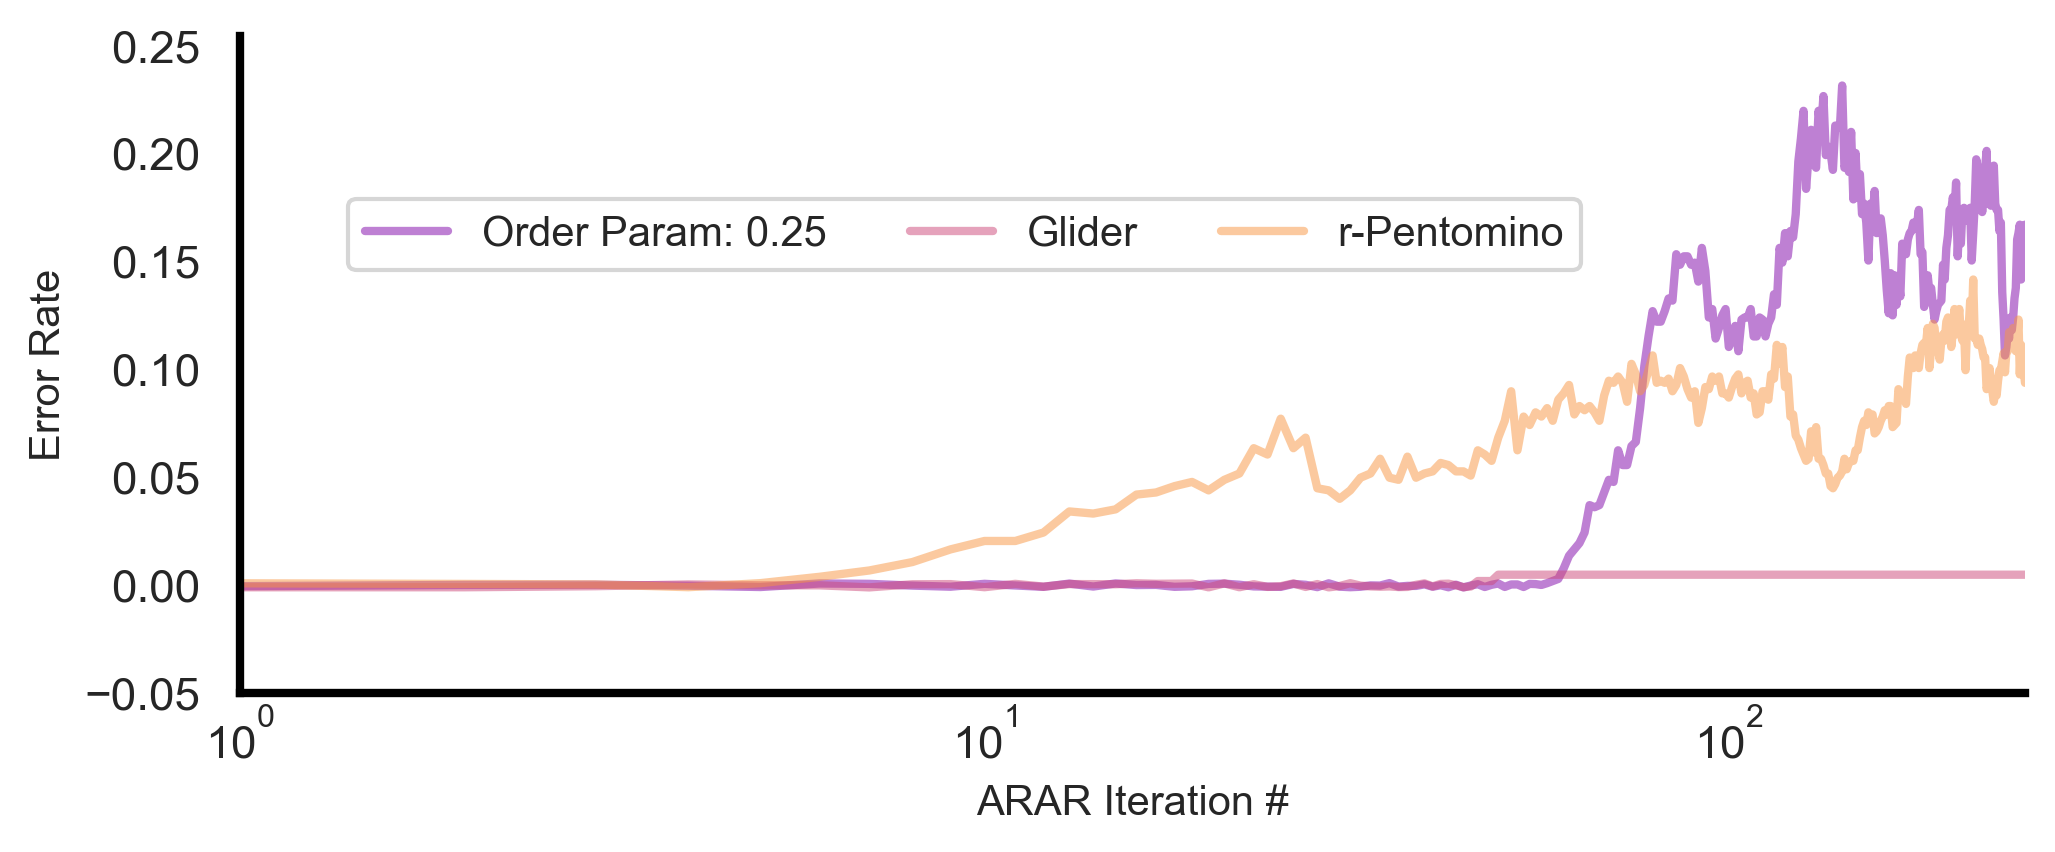

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import glob
import os
from collections import OrderedDict

def calculate_error(gt_state, pred_state):
    if len(gt_state) != len(pred_state):
        return 1.0
    errors = sum(g != p for g, p in zip(gt_state, pred_state))
    return errors / len(gt_state)

def plot_error_vs_state(base_dir):
    names = [
        "Order Param: 0", "Order Param: 0.25", "Order Param: 0.5", "Order Param: 0.75", "Order Param: 1",
        "Glider", "Cloverleaf", "Hammerhead Spaceship", "Blinkers", "r-Pentomino"
    ]
    
    sample_folders = [f.path for f in os.scandir(base_dir) if f.is_dir() and f.name.startswith("sample_")]
    sample_data = OrderedDict()
    
    for sample_folder in sample_folders:
        csv_files = glob.glob(os.path.join(sample_folder, "*.csv"))
        if not csv_files:
            print(f"No CSV files found in {sample_folder}")
            continue
        
        most_recent_csv = max(csv_files, key=os.path.getmtime)
        df = pd.read_csv(most_recent_csv)
        sample_id = int(os.path.basename(sample_folder).split('_')[1])
        
        errors = [calculate_error(str(df.iloc[0, state]).zfill(1024), str(df.iloc[1, state]).zfill(1024)) 
                  for state in range(1, df.shape[1])]
        
        # Only include samples that have at least one non-zero error
        if any(error > 0 for error in errors):
            sample_data[sample_id] = errors

    # Apply the style
    sns.set(style="whitegrid", rc={
        'figure.figsize': (7.01, 2),
        'figure.dpi': 300,
        'lines.linewidth': 2.0,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.edgecolor': 'black',
        'axes.linewidth': 2.0,
        'xtick.direction': 'out',
        'ytick.direction': 'out',
        'xtick.major.width': 0,
        'ytick.major.width': 0,
        'xtick.major.size': 0,
        'ytick.major.size': 6,
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'legend.fontsize': 10,
        'legend.title_fontsize': 10,
        'axes.grid': False
    })

    # Create the figure with a combined GridSpec layout
    fig = plt.figure(figsize=(7.01, 3), dpi=300)
    gs = gridspec.GridSpec(1, 1)
    ax = plt.subplot(gs[0])

    # Generate a discrete color palette
    plasma_discrete = sns.color_palette("plasma", len(sample_data))

    # Plot the data with jitter
    jitter_amount = 0.001  # Amount of jitter to apply to y-values
    for i, (sample_id, errors) in enumerate(sorted(sample_data.items()), 1):
        errors_with_jitter = [error + np.random.uniform(-jitter_amount, jitter_amount) if error == 0 else error for error in errors]
        
        sns.lineplot(x=range(1, len(errors) + 1), y=errors_with_jitter, 
                     label=f'{names[sample_id-1]}', color=plasma_discrete[i-1], 
                     linewidth=2, alpha=0.5, ax=ax, marker='')  # No markers

    # Set axis limits and labels
    ax.set_xlim(1, len(errors))
    ax.set_ylim(-0.05, max(max(errors) for errors in sample_data.values()) * 1.1)
    ax.set_xlabel('ARAR Iteration #')
    ax.set_ylabel('Error Rate')

    # Adjust legend
    bbox_transform = fig.transFigure
    ax.legend(title='', loc='lower center', bbox_to_anchor=(0.47, 0.65), 
              ncol=3, frameon=True, bbox_transform=bbox_transform)

    # Ensure all spines have the same width and set z-order
    for spine in ax.spines.values():
        spine.set_linewidth(2.0)
        spine.set_zorder(3)

    # Define max_error and handle cases for min_error gracefully
    max_error = max(max(errors) for errors in sample_data.values())
    min_error_values = [min(errors) for errors in sample_data.values() if min(errors) > 0]

    if min_error_values:  # Check if there are non-zero error values
        min_error = min(min_error_values)
    else:
        min_error = 1e-4  # Set a small default if no non-zero error is found

    # Set y-axis to logarithmic scale if needed
    if max_error / min_error > 100:
        # ax.set_yscale('log')
        ax.set_ylim(min(-.05, min_error), max_error * 1.1)

    ax.set_xscale('log')
    # Add title
    # plt.title('Error vs State for Samples with Errors', fontsize=12)

    plt.tight_layout()
    plt.show()

# Example usage
base_dir = "ARAR"  # Replace with the actual base directory containing sample subfolders
plot_error_vs_state(base_dir)


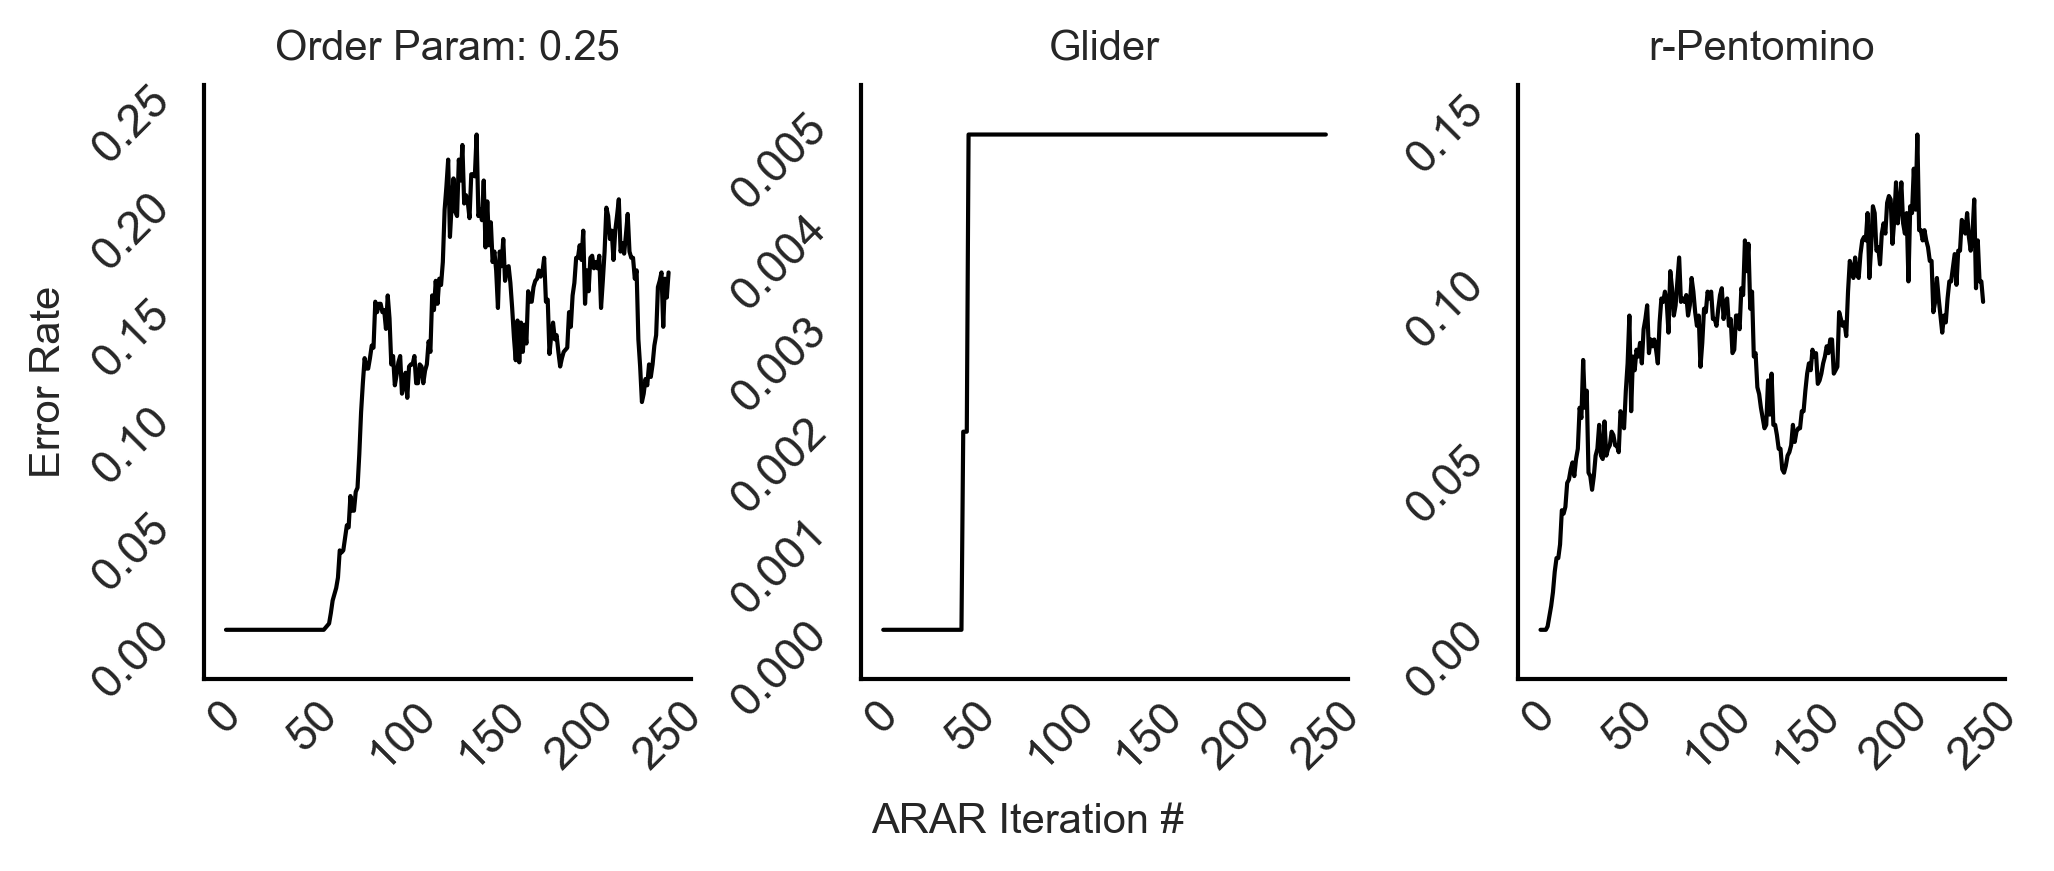

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from collections import OrderedDict

def calculate_error(gt_state, pred_state):
    if len(gt_state) != len(pred_state):
        return 1.0
    errors = sum(g != p for g, p in zip(gt_state, pred_state))
    return errors / len(gt_state)

def plot_error_vs_state(base_dir):
    names = [
        "Order Param: 0", "Order Param: 0.25", "Order Param: 0.5", "Order Param: 0.75", "Order Param: 1",
        "Glider", "Cloverleaf", "Hammerhead Spaceship", "Blinkers", "r-Pentomino"
    ]
    
    sample_folders = [f.path for f in os.scandir(base_dir) if f.is_dir() and f.name.startswith("sample_")]
    sample_data = OrderedDict()
    
    for sample_folder in sample_folders:
        csv_files = glob.glob(os.path.join(sample_folder, "*.csv"))
        if not csv_files:
            print(f"No CSV files found in {sample_folder}")
            continue
        
        most_recent_csv = max(csv_files, key=os.path.getmtime)
        df = pd.read_csv(most_recent_csv)
        sample_id = int(os.path.basename(sample_folder).split('_')[1])
        
        errors = [calculate_error(str(df.iloc[0, state]).zfill(1024), str(df.iloc[1, state]).zfill(1024)) 
                  for state in range(1, df.shape[1])]
        
        # Only include samples that have at least one non-zero error
        if any(error > 0 for error in errors):
            sample_data[sample_id] = errors

    # Apply the style
    sns.set(style="whitegrid", rc={
        'figure.figsize': (3.35, 2),
        'figure.dpi': 300,
        'lines.linewidth': 1,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.edgecolor': 'black',
        'axes.linewidth': 1,
        'xtick.direction': 'out',
        'ytick.direction': 'out',
        'xtick.major.width': 0,
        'ytick.major.width': 0,
        'xtick.major.size': 0,
        'ytick.major.size': 6,
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'legend.fontsize': 10,
        'legend.title_fontsize': 10,
        'axes.grid': False
    })

    # Create a figure with subplots arranged horizontally
    num_samples = len(sample_data)
    fig, axes = plt.subplots(1, num_samples, figsize=(7.01, 3), dpi=300, sharey=False)
    



    # Plot each sample with errors in separate subplots
    for i, (sample_id, errors) in enumerate(sorted(sample_data.items())):
        ax = axes[i] if num_samples > 1 else axes  # Adjust for single subplot scenario
        
        sns.lineplot(x=range(1, len(errors) + 1), y=errors, 
                     label=f'{names[sample_id-1]}', color='black', 
                     alpha=1, ax=ax, marker='')  # No markers

        # Calculate dynamic y-axis limits
        local_min = min(errors) if errors else 0
        local_max = max(errors) if errors else 1
        ax.set_ylim(local_min - (local_max * 0.1), local_max * 1.1)
        
        # Set x-axis ticks and labels
        tick_positions = range(0, len(errors) + 1, max(1, len(errors) // 5))  # Start from 0
        tick_labels = [str(pos) for pos in tick_positions]  # Use labels starting from 0
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=45)
        ax.tick_params(axis='y', rotation=45)
        ax.yaxis.set_tick_params(pad=.5)  # Adjust the value to control the space

        # Set y-axis label only for the first subplot
        if i == 0:
            ax.set_ylabel('Error Rate',fontsize=10)
        else:
            ax.set_ylabel('')

        ax.set_title(names[sample_id-1])
        ax.get_legend().remove()

        # Ensure all spines have the same width
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_zorder(3)

    # Add a single x-axis label for the whole figure
    fig.text(0.5, 0.06, 'ARAR Iteration #', ha='center', va='center', fontsize=10)

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to fit x-axis label
    plt.subplots_adjust(wspace=0.35)  # Adjust the value as needed
    plt.show()

# Example usage
base_dir = "ARAR"  # Replace with the actual base directory containing sample subfolders
plot_error_vs_state(base_dir)


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from PIL import Image
import re

# Define the names to be used for each sample
names = [
    "Order Param: 0", "Order Param: 0.25", "Order Param: 0.5", "Order Param: 0.75", "Order Param: 1",
    "Glider", "Cloverleaf", "Hammerhead Spaceship", "Blinkers", "r-Pentomino"
]

def create_gifs_from_csv(base_dir, temp, output_dir="Figures", fps=5, num_iterations=250):
    """
    Creates looping GIFs from the CSV file, showing the evolution of Ground Truth (GT), Predicted (Pred),
    and Discrepancy states together.

    Parameters:
    base_dir (str): Base directory containing the sample subfolders.
    temp (float): The temperature associated with the data.
    output_dir (str): Directory to save the generated GIFs.
    fps (int): Frames per second for the GIF.
    num_iterations (int): Number of iterations to include in the GIF.
    """
    # Find all sample subdirectories
    sample_dirs = glob.glob(os.path.join(base_dir, "sample_*"))
    
    if not sample_dirs:
        print(f"No sample directories found in {base_dir}")
        return
    
    # Extract numeric sample number and sort
    sample_dirs.sort(key=lambda x: int(re.search(r'sample_(\d+)', x).group(1)))
    
    os.makedirs(output_dir, exist_ok=True)
    
    for sample_dir in sample_dirs:
        csv_path_pattern = os.path.join(sample_dir, f"data_temp_{temp}_*.csv")
        csv_files = glob.glob(csv_path_pattern)
        
        if not csv_files:
            print(f"No CSV files found in {sample_dir} for temperature {temp}")
            continue
        
        # Sort files by modification time and get the most recent one
        csv_files.sort(key=os.path.getmtime, reverse=True)
        csv_path = csv_files[0]
        print(f"Using the most recent CSV file: {csv_path} from {sample_dir}")
        
        # Read the CSV file
        df = pd.read_csv(csv_path)

        # Extract the sample number from the directory name
        sample_num = int(re.search(r'sample_(\d+)', sample_dir).group(1))

        # Determine the number of samples
        num_samples = df.shape[0] // 2  # Since we have GT and Pred rows, divide by 2

        # Get the name for the current sample from the names list
        sample_name = names[sample_num - 1]  # Adjust for zero-based indexing
        
        for i in range(num_samples):
            frames = []
            for j in range(num_iterations):
                fig, axes = plt.subplots(3, 1, figsize=(3, 9), dpi=300)

                # Convert states to strings and pad with zeros if necessary
                gt_state = str(df.iloc[2 * i, j + 1]).zfill(1024)
                pred_state = str(df.iloc[2 * i + 1, j + 1]).zfill(1024)

                # GT image
                plot_image(axes[0], gt_state, f"GT", "gray")
                # Predicted image
                plot_image(axes[1], pred_state, f"Predicted", "gray")
                # Discrepancy image
                discrepancy_matrix = calculate_discrepancy_matrix(gt_state, pred_state)
                plot_discrepancy(axes[2], discrepancy_matrix, f"Error")

                top_title = f"{sample_name} | Temperature: {temp} | Iteration: {j+1}/{num_iterations}"

                # Add titles using the extracted sample name
                fig.suptitle(top_title, fontsize=350 // len(top_title))

                plt.tight_layout(pad=2.0)
                
                # Save the figure to a temporary file
                temp_file = os.path.join(output_dir, f"temp_frame_{j}.png")
                plt.savefig(temp_file, dpi=300)
                plt.close(fig)
                
                # Add the image to the frame list
                frames.append(Image.open(temp_file))

            gif_path = os.path.join(output_dir, f"evolution_temp_{temp}_sample_{sample_num}.gif")
            frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=1000 // fps, loop=0)
            print(f"GIF saved at {gif_path}")

            # Clean up temporary files
            for frame in frames:
                os.remove(frame.filename)

# Helper functions for plotting and processing
def plot_image(ax, state, ylabel, cmap):
    """
    Plots an image from the state data.

    Parameters:
    ax (Axes): The axes to plot on.
    state (str): The state as a string of 0s and 1s.
    ylabel (str): The label for the y-axis.
    cmap (str): The color map for the image.
    """
    ax.set_ylabel(ylabel, fontsize=10, rotation=90, labelpad=10, va='center')
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Turn off ticks and labels
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)  # Set the width of the spines
    if not is_perfect_square(len(state)) or not check_state_length(state):
        ax.text(0.5, 0.5, "DATA NOT SQUARE", fontsize=10, ha='center', va='center', rotation=45)
    else:
        ax.imshow(1 - convert_to_square_image(state, cell_size=10), cmap=cmap, vmin=0, vmax=1)

def plot_discrepancy(ax, discrepancy_matrix, ylabel):
    """
    Plots the discrepancy matrix.

    Parameters:
    ax (Axes): The axes to plot on.
    discrepancy_matrix (ndarray): The discrepancy matrix to plot.
    ylabel (str): The label for the y-axis.
    """
    sns.heatmap(discrepancy_matrix, cmap="plasma", cbar=False, square=True, ax=ax)
    ax.set_ylabel(ylabel, fontsize=10, rotation=90, labelpad=10, va='center')
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Turn off ticks and labels

def calculate_discrepancy_matrix(gt_state, pred_state):
    """
    Calculate the discrepancy matrix between GT and Predicted states.

    Parameters:
    gt_state (str): The ground truth state.
    pred_state (str): The predicted state.

    Returns:
    np.ndarray: The discrepancy matrix.
    """
    # Ensure gt_state and pred_state are strings of length 1024
    if len(gt_state) == len(pred_state) == 1024:
        discrepancy_matrix = np.array([
            1 if gt_state[k] != pred_state[k] else 0
            for k in range(len(gt_state))
        ]).reshape((32, 32))
    else:
        print('State lengths are not 1024, creating default discrepancy matrix.')
        discrepancy_matrix = np.full((32, 32), 0.5)  # Handle error gracefully
    
    return discrepancy_matrix

def convert_to_square_image(state, cell_size=1):
    """
    Converts a string state representation into a square image with adjustable cell size.
    
    Parameters:
    state (str): The state as a string of 0s and 1s.
    cell_size (int): The size of each cell in pixels. Default is 1.
    
    Returns:
    2D numpy array representing the square image with adjusted cell size.
    """
    length = len(state)
    size = int(np.sqrt(length))
    assert size * size == length, "State length is not a perfect square"
    image = np.array([int(pixel) for pixel in state]).reshape((size, size))
    
    # Adjust the cell size by repeating the rows and columns
    image = np.kron(image, np.ones((cell_size, cell_size)))
    
    return image

def is_perfect_square(length):
    """
    Check if a number is a perfect square.
    """
    size = int(np.sqrt(length))
    return size * size == length

def check_state_length(state):
    """
    Check if the state has 1024 entries.
    """
    return len(state) == 1024

# Only generate GIFs for temperature = 0 with 250 iterations
temp = 0
base_dir = "ARAR"
create_gifs_from_csv(base_dir, temp, fps=15, num_iterations=250)


Using the most recent CSV file: ARAR\sample_1\data_temp_0_epoch_50_sample_1_v1.csv from ARAR\sample_1
GIF saved at Figures\evolution_temp_0_sample_1.gif
Using the most recent CSV file: ARAR\sample_2\data_temp_0_epoch_50_sample_2_v1.csv from ARAR\sample_2
GIF saved at Figures\evolution_temp_0_sample_2.gif
Using the most recent CSV file: ARAR\sample_3\data_temp_0_epoch_50_sample_3_v1.csv from ARAR\sample_3
GIF saved at Figures\evolution_temp_0_sample_3.gif
Using the most recent CSV file: ARAR\sample_4\data_temp_0_epoch_50_sample_4_v1.csv from ARAR\sample_4
GIF saved at Figures\evolution_temp_0_sample_4.gif
Using the most recent CSV file: ARAR\sample_5\data_temp_0_epoch_50_sample_5_v1.csv from ARAR\sample_5
GIF saved at Figures\evolution_temp_0_sample_5.gif
Using the most recent CSV file: ARAR\sample_6\data_temp_0_epoch_50_sample_6_v1.csv from ARAR\sample_6
GIF saved at Figures\evolution_temp_0_sample_6.gif
Using the most recent CSV file: ARAR\sample_7\data_temp_0_epoch_50_sample_7_v1.csv